- `AT` - Ambient temperature C 
- `AP` - Ambient pressure mbar 
- `AH` - Ambient humidity %
- `AFDP` - Air filter difference pressure mbar 
- `GTEP` - Gas turbine exhaust pressure mbar 
- `TIT` - Turbine inlet temperature C 
- `TAT` - Turbine after temperature C 
- `CDP` - Compressor discharge pressure mbar
- `TEY` - Turbine energy yield MWH 
- `NOx` - Nitrogen oxides mg/m3
- `CO` - Carbon monoxide mg/m3 (zmienna docelowa)

## 02. Feature Engeenering

In [ ]:
import utils2 as u

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import r2_score, f1_score

import eli5
import xgbfir

import warnings
warnings.simplefilter(action='ignore')

%load_ext autoreload
%autoreload 2

In [ ]:
df_all = u.prepare_data()

df_train, _ = u.split_data(df_all)
feats = u.get_feats(df_all)

In [ ]:
df_all.head(3)

,id,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,CO,sample,log_CO
0,21690,18.669,1013.7,99.439,3.7778,19.425,1055.7,549.87,109.18,10.473,57.356,5.40360,train,1.856860
1,13065,29.258,1015.0,49.987,4.2985,29.813,1100.1,545.45,148.20,13.168,47.941,0.87879,train,0.630628
2,18180,11.884,1018.6,92.583,3.1310,24.080,1083.0,550.02,131.43,11.798,61.583,1.17850,train,0.778637


In [ ]:
df_train.head(3)

,id,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,CO,sample,log_CO
0,21690,18.669,1013.7,99.439,3.7778,19.425,1055.7,549.87,109.18,10.473,57.356,5.40360,train,1.856860
1,13065,29.258,1015.0,49.987,4.2985,29.813,1100.1,545.45,148.20,13.168,47.941,0.87879,train,0.630628
2,18180,11.884,1018.6,92.583,3.1310,24.080,1083.0,550.02,131.43,11.798,61.583,1.17850,train,0.778637


In [ ]:
print(feats)

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX', 'GTEP_cat', 'TAT/TIT', 'random_uniform_0', 'random_normal_0', 'random_lognormal_0', 'random_exponential_0', 'random_uniform_1', 'random_normal_1', 'random_lognormal_1', 'random_exponential_1', 'random_uniform_2', 'random_normal_2', 'random_lognormal_2', 'random_exponential_2']


In [ ]:
# oryginał

# import warnings

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import utils as u

# import xgboost as xgb
# import catboost as ctb

# import eli5
# import xgbfir

# warnings.simplefilter(action='ignore')

# %load_ext autoreload
# %autoreload 2

##### Cechy ketagoryczne

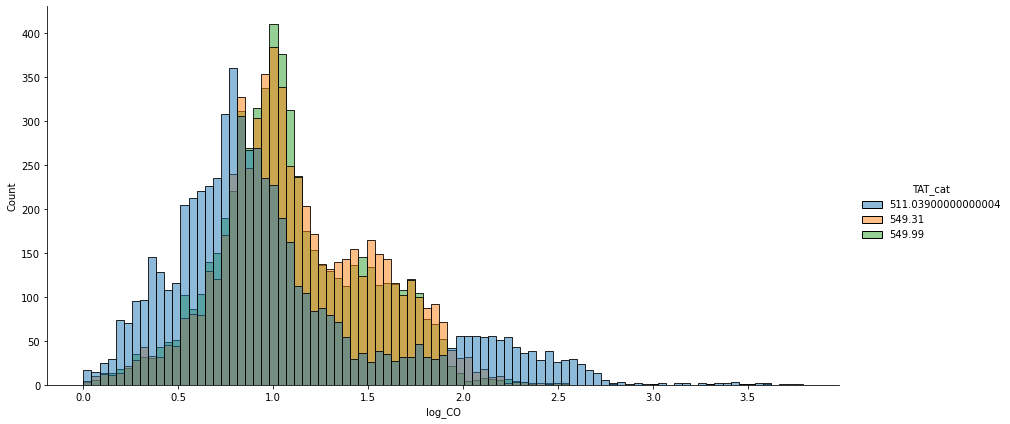

In [ ]:
# Na przykład 1000 wartości dla 10 kwantylów dałoby obiekt kategorialny wskazujący przynależność do 
# kwantyli dla każdego punktu danych. https://pandas.pydata.org/docs/reference/api/pandas.qcut.html

df_train['TAT_cat'] = pd.qcut(df_train['TAT'], 3).apply(lambda x: x.left)
sns.displot(df_train, x='log_CO', hue='TAT_cat', height=6, aspect=2);

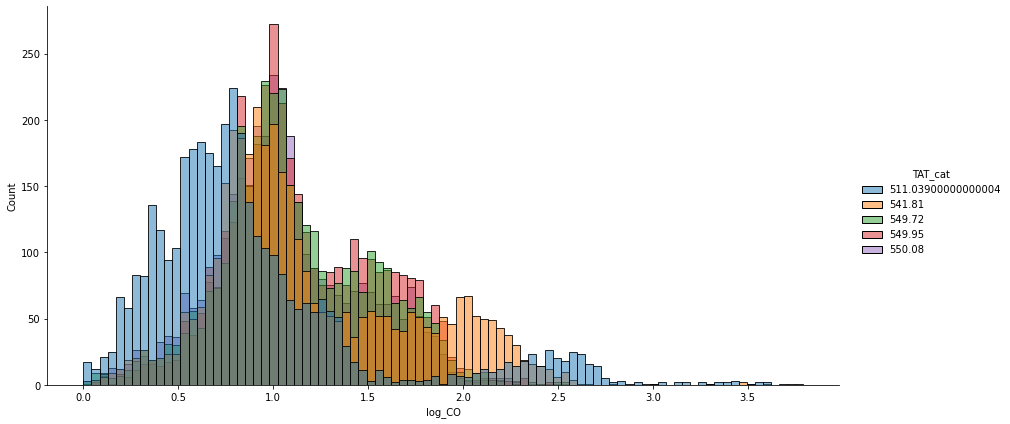

In [ ]:
df_train['TAT_cat'] = pd.qcut(df_train['TAT'], 5).apply(lambda x: x.left)
sns.displot(df_train, x='log_CO', hue='TAT_cat', height=6, aspect=2);

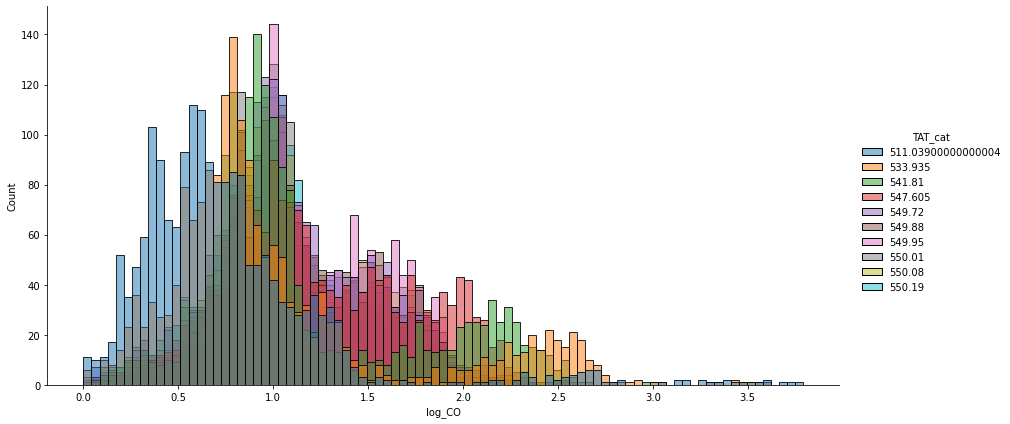

In [ ]:
df_train['TAT_cat'] = pd.qcut(df_train['TAT'], 10).apply(lambda x: x.left)
sns.displot(df_train, x='log_CO', hue='TAT_cat', height=6, aspect=2);

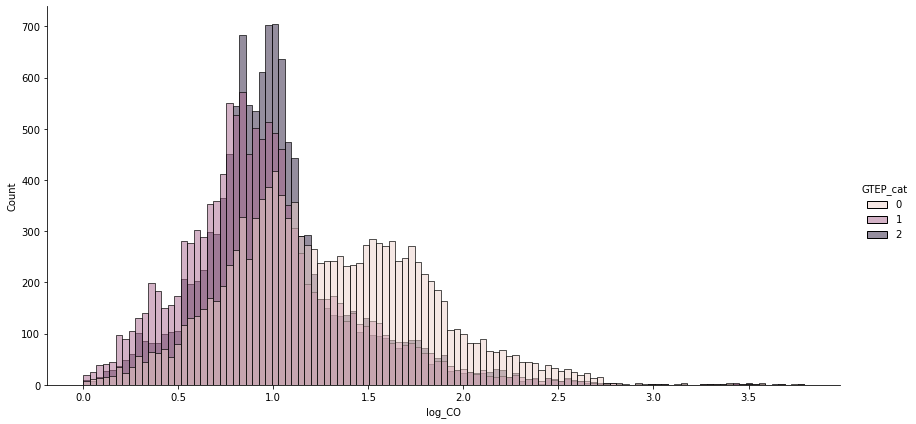

In [ ]:
df_all['GTEP_cat'] = pd.qcut(df_all['GTEP'], 3).factorize()[0]
sns.displot(df_all, x='log_CO', hue='GTEP_cat', height=6, aspect=2);

Wynik: Finalnie niewiele wniosły do modelu

###### Łączenie cech

In [ ]:
df_all['TAT/TIT'] =  df_all['TAT']/df_all['TIT']

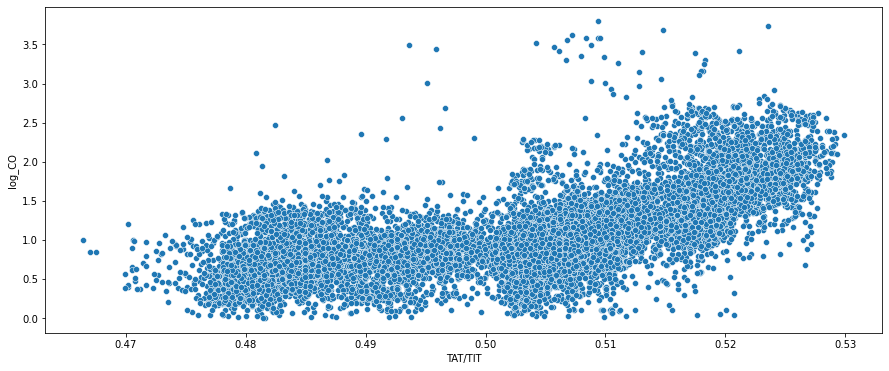

In [ ]:
plt.figure(figsize=(15, 6));
sns.scatterplot(df_all['TAT/TIT'], df_all['log_CO']);

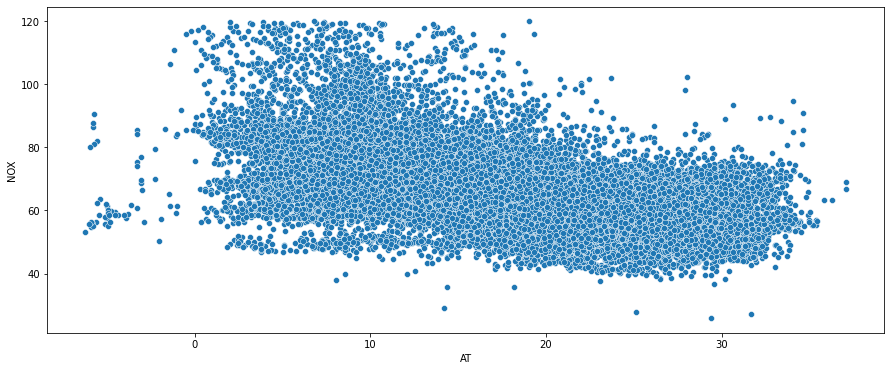

In [ ]:
plt.figure(figsize=(15, 6));
sns.scatterplot(df_all['AT'], df_all['NOX']);

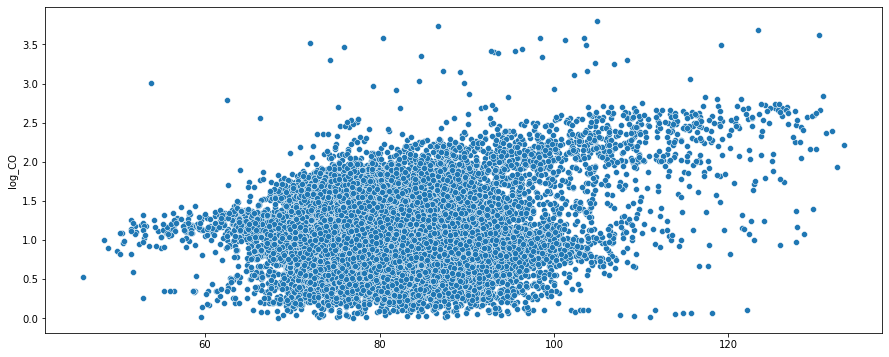

In [ ]:
plt.figure(figsize=(15, 6));
sns.scatterplot(df_all['AT'] + df_all['NOX'], df_all['log_CO']);

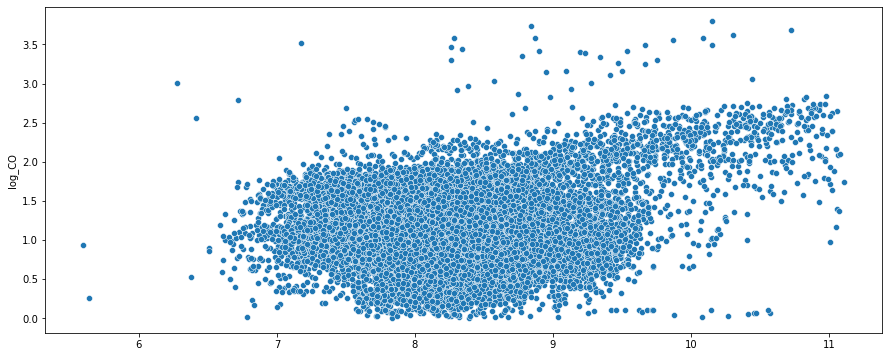

In [ ]:
plt.figure(figsize=(15, 6));
sns.scatterplot(np.sqrt(df_all['AFDP'] + df_all['NOX']), df_all['log_CO']);

###### Model do szukania cech

In [ ]:
df_all = u.add_random_feats(df_all, no_feats=3)

In [ ]:
df_all

,id,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,...,random_lognormal_0,random_exponential_0,random_uniform_1,random_normal_1,random_lognormal_1,random_exponential_1,random_uniform_2,random_normal_2,random_lognormal_2,random_exponential_2
0,21690,18.669,1013.7,99.439,3.7778,19.425,1055.7,549.87,109.18,10.473,...,1.642318,0.798074,0.857525,-1.082779,1.445869,0.790154,0.994430,0.883779,2.360319,4.572231
1,13065,29.258,1015.0,49.987,4.2985,29.813,1100.1,545.45,148.20,13.168,...,7.570437,4.331783,0.594442,-0.366671,0.911416,1.069485,0.654635,-0.683224,3.646896,0.689865
2,18180,11.884,1018.6,92.583,3.1310,24.080,1083.0,550.02,131.43,11.798,...,0.315221,0.520730,0.553055,-1.414997,1.085961,0.026681,0.278365,0.688294,2.581701,1.105195
3,11727,27.668,1015.0,43.269,3.3885,20.591,1062.8,550.17,111.69,10.737,...,0.565293,0.125847,0.154725,1.176485,4.260691,4.493274,0.926845,0.733170,2.311905,0.891349
4,19323,20.118,1005.4,97.557,5.0886,30.113,1099.8,545.66,148.27,13.161,...,0.732701,0.501193,0.995685,1.430854,1.002950,1.690386,0.927886,0.975982,0.937209,0.273910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18362,10105,25.054,1002.5,93.655,4.1491,25.306,1078.8,550.00,128.66,11.787,...,0.673951,1.469323,0.228680,-0.916676,0.957963,0.392949,0.223106,0.016583,2.136238,1.083377
18363,18931,16.803,1022.1,53.964,3.5783,24.248,1087.7,550.14,133.79,11.851,...,1.842098,0.202079,0.081837,0.385900,0.208531,1.039142,0.686779,-0.716346,0.765925,0.169071
18364,8064,12.120,1013.6,90.187,5.6507,32.289,1100.1,530.07,159.43,13.897,...,2.474492,1.635168,0.337782,0.698148,0.325621,0.016158,0.968874,0.795102,1.491996,0.321150
18365,27308,11.432,1010.5,83.703,3.6061,24.101,1084.7,549.94,133.65,11.744,...,2.448321,1.538042,0.542596,2.164641,0.343306,1.606827,0.112287,-0.453643,0.578349,0.186188


In [ ]:
df_train, _ = u.split_data(df_all)
feats = u.get_feats(df_all)

In [ ]:
print(feats)

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX', 'GTEP_cat', 'TAT/TIT', 'random_uniform_0', 'random_normal_0', 'random_lognormal_0', 'random_exponential_0', 'random_uniform_1', 'random_normal_1', 'random_lognormal_1', 'random_exponential_1', 'random_uniform_2', 'random_normal_2', 'random_lognormal_2', 'random_exponential_2']


### Gradient Boosting (`XGBoost, LightGBM i CatBoost`)

##### Drzewo decyzyjne `DecisionTreeRegressor`

Wall time: 203 ms


Weight,Feature
0.6499,TIT
0.2101,TAT
0.0472,TAT/TIT
0.0274,random_uniform_2
0.0224,NOX
0.0141,TEY
0.0136,GTEP
0.0056,AH
0.0053,random_normal_1
0.0036,AFDP


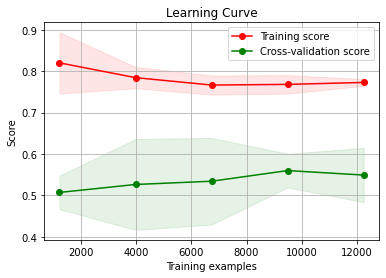

In [ ]:
dtr_rmodel = u.DecisionTreeRegressor(random_state=0, max_depth=5)
%time dtr_rmodel.fit(df_train[feats].values, df_train[u.TARGET]); # etap trenowania

plot_learning_curve(dtr_rmodel, df_train[feats].values, df_train[u.TARGET], cv=3, random_state=0, shuffle=True)
eli5.show_weights(dtr_rmodel, feature_names = feats)

##### Las losowy `Random Forest`

Wall time: 12.6 s


Weight,Feature
0.6371 ± 0.0633,TIT
0.2160 ± 0.0559,TAT
0.0367 ± 0.0535,TAT/TIT
0.0348 ± 0.0362,NOX
0.0163 ± 0.0153,TEY
0.0073 ± 0.0227,random_lognormal_1
0.0071 ± 0.0101,AFDP
0.0055 ± 0.0200,AH
0.0052 ± 0.0198,AP
0.0049 ± 0.0174,random_exponential_2


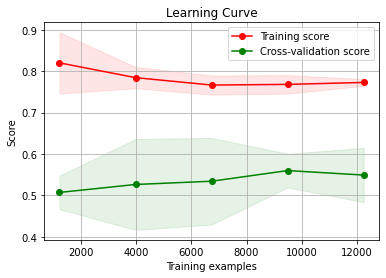

In [ ]:
rfr_rmodel = u.RandomForestRegressor(random_state=0, n_estimators=100, max_depth=5) # n_estimators to Liczba drzew w lesie
%time rfr_rmodel.fit(df_train[feats].values, df_train[u.TARGET]); # etap trenowania

plot_learning_curve(dtr_rmodel, df_train[feats].values, df_train[u.TARGET], cv=3, random_state=0, shuffle=True)
eli5.show_weights(rfr_rmodel, feature_names = feats)

##### XGBRegressor

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

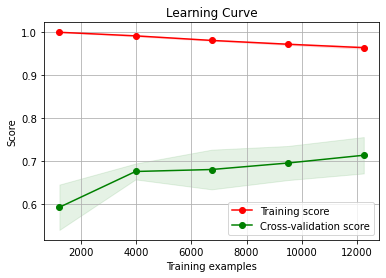

In [ ]:
xgb_rmodel = u.xgb.XGBRegressor(max_depth=6, n_estimators=100, random_state=0)
xgb_rmodel.fit(df_train[feats].values, df_train[u.TARGET]);

plot_learning_curve(xgb_rmodel, df_train[feats].values, df_train[u.TARGET], cv=3, random_state=0, shuffle=True)

# TypeError: 'NoneType' object is not iterable
# eli5.show_weights(xgb_rmodel, feature_names = feats)

##### LGBMRegressor

Weight,Feature
0.5582,TIT
0.2084,TAT
0.0605,NOX
0.0363,TEY
0.0296,AFDP
0.0154,TAT/TIT
0.0136,AT
0.0119,AH
0.0110,CDP
0.0105,GTEP


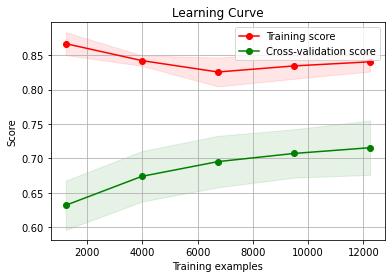

In [ ]:
lgbm_rmodel = u.lgb.LGBMRegressor(max_depth=6, n_estimators=100, random_state=0)
lgbm_rmodel.fit(df_train[feats].values, df_train[u.TARGET]);

plot_learning_curve(lgbm_rmodel, df_train[feats].values, df_train[u.TARGET], cv=3, random_state=0, shuffle=True)

eli5.show_weights(lgbm_rmodel, feature_names = feats)

##### CatBoostRegressor

Weight,Feature
0.2659,TAT
0.1797,TIT
0.1225,NOX
0.0774,TEY
0.0732,AFDP
0.0484,TAT/TIT
0.0421,AT
0.0404,GTEP
0.0400,AH
0.0264,AP


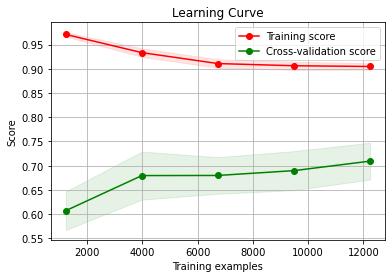

In [ ]:
ctb_rmodel = u.ctb.CatBoostRegressor(depth=6, n_estimators=100, random_state=0, verbose=0)
ctb_rmodel.fit(df_train[feats].values, df_train[u.TARGET]);

plot_learning_curve(ctb_rmodel, df_train[feats].values, df_train[u.TARGET], cv=3, random_state=0, shuffle=True)

eli5.show_weights(ctb_rmodel, feature_names = feats) 

Jak interpretować różnicę w wagach pomiędzy LGBMRegressor a CatBoostRegressor?

##### xgbfir (Feature importance)

Algorytmy drzewiaste dają możliwość zobaczenia ważności cech. Warto również rozumieć, jak to działa pod spodem.

Są trzy strategie, jak można wyliczyć ważność:
- **frequence** (jak często cecha pojawiła się w podziałach)
- **cover** (jak duży wpływ ma, czyli na ile danych wpłynęła: na 1% czy 99%)
- **gain** (na ile cecha pomogła zmniejszyć entropię zbioru, dzieląc go na 2 podzbiory)

Zwykle (domyślnie) bierze się pod uwagę `frequence`, ale taka strategia może być słaba. Pomyśl o tym  w ten sposób. Mamy drzewo i następuje podział pod wpływem danej cechy, ale nie wpływa to na zmniejszenie entropii. Wartość tej cechy wg `frequence` wzrośnie, natomiast wg `gain` nie. Dlatego jest dość istotna różnica pomiędzy podziałem, po którym prawie nic się nie zmieniło i takim, po którym entropia (mieszanka/nieczystość) zmalała do zera.

In [ ]:
xgbfir.saveXgbFI(xgb_rmodel, feature_names=feats, OutputXlsxFile='xgb_feats_selector.xlsx')

In [ ]:
pd.read_excel('xgb_feats_selector.xlsx', 'Interaction Depth 0').head(15)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,TIT,89001.568412,187,42.672220,0.228194,475.944216,84223.855704,1,8,3,2,1,1,2.666667,41.572193,3.663102
1,TAT,33229.044323,192,22.848089,0.119000,173.067939,4503.344985,2,7,13,16,2,2,7.000000,40.557292,3.677083
2,NOX,12819.929227,384,61.831537,0.161020,33.385232,1282.890510,3,2,1,9,4,4,3.833333,39.317708,3.656250
3,TAT/TIT,5526.014073,145,35.716106,0.246318,38.110442,557.084943,4,11,6,1,3,6,5.166667,47.834483,3.489655
4,TEY,5494.081598,181,37.831264,0.209013,30.354042,2179.960626,5,9,5,4,5,3,5.166667,40.116022,3.674033
5,AFDP,5206.183375,327,34.178428,0.104521,15.921050,751.099069,6,3,7,17,7,5,7.500000,40.605505,4.110092
6,AT,4674.011649,552,29.883263,0.054136,8.467412,281.802956,7,1,8,22,13,9,10.000000,47.510870,4.202899
7,AH,4267.456790,322,42.837853,0.133037,13.252971,317.741289,8,4,2,14,8,8,7.333333,47.748447,3.903727
8,GTEP,2240.070038,243,42.621257,0.175396,9.218395,388.286860,9,6,4,7,10,7,7.166667,47.703704,3.868313
9,AP,1651.021913,305,25.947675,0.085074,5.413187,225.540326,10,5,10,21,15,10,11.833333,49.262295,4.118033


In [ ]:
pd.read_excel('xgb_feats_selector.xlsx', 'Interaction Depth 1').head(15)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,TAT|TIT,107616.045711,19,2.279103,0.119953,5664.002406,15895.148045,1,54,50,31,1,3,23.333333,14.578947,2.105263
1,TIT|TIT,77337.179270,15,7.029620,0.468641,5155.811951,62945.166435,2,74,12,1,2,1,15.333333,26.000000,2.733333
2,TAT|TAT,35556.835633,23,5.696287,0.247665,1545.949375,3461.318668,3,42,24,19,3,4,15.833333,38.260870,3.043478
3,TAT|TAT/TIT,20446.053911,14,3.941359,0.281526,1460.432422,860.632641,4,77,32,13,4,10,23.333333,17.642857,3.214286
4,TEY|TIT,19611.754038,22,8.868235,0.403102,891.443365,15960.204900,5,44,8,4,5,2,11.333333,34.636364,3.363636
5,NOX|TAT,15473.926163,52,5.332517,0.102548,297.575503,570.039367,6,9,26,41,8,12,17.000000,27.673077,3.634615
6,TAT|TEY,9805.234238,24,3.001143,0.125048,408.551427,713.903477,7,38,46,30,6,11,23.000000,22.708333,3.500000
7,NOX|TEY,6787.612571,46,5.094849,0.110758,147.556795,1225.590105,8,13,27,36,14,6,17.333333,28.782609,3.826087
8,AT|NOX,6587.394885,104,7.734891,0.074374,63.340335,225.580974,9,1,10,60,25,18,20.500000,39.644231,3.817308
9,AFDP|NOX,6060.123890,85,8.493248,0.099921,71.295575,917.080346,10,3,9,44,22,7,15.833333,27.552941,4.058824


In [ ]:
pd.read_excel('xgb_feats_selector.xlsx', 'Interaction Depth 2').head(15)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,TAT|TAT|TIT,132351.595545,10,1.000980,0.100098,13235.159554,13223.887324,1,29,35,37,4,3,18.166667,2.000000,2.800000
1,TAT|TAT/TIT|TIT,79770.002894,3,0.059675,0.019892,26590.000965,1628.217831,2,81,83,78,1,12,42.833333,0.666667,2.333333
2,TAT|TIT|TIT,69254.900776,5,1.023794,0.204759,13850.980155,10880.454646,3,65,34,14,3,4,20.500000,4.000000,2.000000
3,TAT|TAT|TEY,53904.864265,10,0.607590,0.060759,5390.486426,3351.378306,4,30,52,57,7,8,26.333333,13.000000,3.500000
4,TIT|TIT|TIT,44937.648056,2,1.410759,0.705380,22468.824028,31272.076779,5,87,22,1,2,1,19.666667,3.000000,2.000000
5,NOX|TEY|TIT,23421.416615,10,3.032233,0.303223,2342.141661,7400.695298,6,31,3,7,11,5,10.500000,15.700000,3.000000
6,AFDP|TIT|TIT,22202.840899,4,0.740118,0.185029,5550.710225,15705.819738,7,71,46,18,6,2,25.000000,38.000000,4.000000
7,AH|TAT|TAT/TIT,19004.416704,4,0.007732,0.001933,4751.104176,9.822263,8,72,93,94,8,80,59.166667,4.000000,3.500000
8,NOX|TAT|TAT,17864.105068,13,1.044648,0.080358,1374.161928,83.007862,9,19,32,46,18,49,28.833333,18.307692,3.615385
9,NOX|TAT|TIT,13388.181572,8,0.460634,0.057579,1673.522696,1366.721917,10,42,55,59,13,14,32.166667,9.250000,2.750000


##### Finalna postać funkcji feature_engeenering:

In [ ]:
df_all.columns

Index(['id', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP',
       'NOX', 'CO', 'sample', 'log_CO', 'GTEP_cat', 'TAT/TIT',
       'random_uniform_0', 'random_normal_0', 'random_lognormal_0',
       'random_exponential_0', 'random_uniform_1', 'random_normal_1',
       'random_lognormal_1', 'random_exponential_1', 'random_uniform_2',
       'random_normal_2', 'random_lognormal_2', 'random_exponential_2'],
      dtype='object')

In [ ]:
# Wprowadzone do pliku: utils2.py

# def feature_engeenering(df_all):

#     df_all['CO_cat'] = (df_all['CO'] < df_all['CO'].median()).astype(int)
    
#     for col in ['TAT', 'TIT', 'TEY']:
#         df_all[f'log_{col}'] = np.log1p(df_all[col])
    
#     df_all['TAT - TIT'] =  df_all['TAT'] - df_all['TIT']
#     df_all['TAT - TEY'] =  df_all['TAT'] - df_all['TEY']
#     df_all['TIT - TEY'] =  df_all['TIT'] - df_all['TEY']
#     df_all['TIT / TEY'] = df_all['TIT'] / df_all['TEY']
#     df_all['TAT / TEY'] = df_all['TAT'] / df_all['TEY']
#     df_all['TIT / TAT'] = df_all['TIT'] / df_all['TAT'] 
#     df_all['AT + NOX']  = df_all['AT'] + df_all['NOX']
#     df_all['AFDP_NOX'] = df_all['AFDP'] + df_all['NOX']

#     for feat, bins in product(['TIT', 'TAT', 'TEY'], [2,3,5,10]):
#         df_all[f'{feat}_cat_{bins}'] = pd.qcut(df_all[feat], bins).apply(lambda x: x.left)
    
#     df_all['GTEP_cat'] = pd.qcut(df_all['GTEP'], 3).apply(lambda x: x.left)
          
#     return df_all

In [ ]:
df_all = u.feature_engeenering(df_all)

In [ ]:
df_all.columns

Index(['id', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP',
       'NOX', 'CO', 'sample', 'log_CO', 'GTEP_cat', 'TAT/TIT',
       'random_uniform_0', 'random_normal_0', 'random_lognormal_0',
       'random_exponential_0', 'random_uniform_1', 'random_normal_1',
       'random_lognormal_1', 'random_exponential_1', 'random_uniform_2',
       'random_normal_2', 'random_lognormal_2', 'random_exponential_2',
       'CO_cat', 'log_TAT', 'log_TIT', 'log_TEY', 'TAT - TIT', 'TAT - TEY',
       'TIT - TEY', 'TIT / TEY', 'TAT / TEY', 'TIT / TAT', 'AT + NOX',
       'AFDP_NOX', 'TIT_cat_2', 'TIT_cat_3', 'TIT_cat_5', 'TIT_cat_10',
       'TAT_cat_2', 'TAT_cat_3', 'TAT_cat_5', 'TAT_cat_10', 'TEY_cat_2',
       'TEY_cat_3', 'TEY_cat_5', 'TEY_cat_10'],
      dtype='object')

In [ ]:
df_all2 = u.get_feats(df_all)
df_all2

['AT',
 'AP',
 'AH',
 'AFDP',
 'GTEP',
 'TIT',
 'TAT',
 'TEY',
 'CDP',
 'NOX',
 'GTEP_cat',
 'TAT/TIT',
 'random_uniform_0',
 'random_normal_0',
 'random_lognormal_0',
 'random_exponential_0',
 'random_uniform_1',
 'random_normal_1',
 'random_lognormal_1',
 'random_exponential_1',
 'random_uniform_2',
 'random_normal_2',
 'random_lognormal_2',
 'random_exponential_2',
 'log_TAT',
 'log_TIT',
 'log_TEY',
 'TAT - TIT',
 'TAT - TEY',
 'TIT - TEY',
 'TIT / TEY',
 'TAT / TEY',
 'TIT / TAT',
 'AT + NOX',
 'AFDP_NOX',
 'TIT_cat_2',
 'TIT_cat_3',
 'TIT_cat_5',
 'TIT_cat_10',
 'TAT_cat_2',
 'TAT_cat_3',
 'TAT_cat_5',
 'TAT_cat_10',
 'TEY_cat_2',
 'TEY_cat_3',
 'TEY_cat_5',
 'TEY_cat_10']